<a href="https://colab.research.google.com/github/elsheikh21/boats-classification/blob/master/yet_another_trail.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!rm -rf sample_data
!git clone https://github.com/elsheikh21/boats-classification
!cd boats-classification

Cloning into 'boats-classification'...
remote: Enumerating objects: 6800, done.
remote: Counting objects: 100% (6800/6800), done.
remote: Compressing objects: 100% (6792/6792), done.
remote: Total 6800 (delta 6), reused 6795 (delta 4), pack-reused 0
Receiving objects: 100% (6800/6800), 334.53 MiB | 36.06 MiB/s, done.
Resolving deltas: 100% (6/6), done.
Checking out files: 100% (6700/6700), done.


In [0]:
import os
import math
import numpy as np
import pandas as pd
from numpy import savetxt
from keras import regularizers
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.callbacks import CSVLogger
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.layers import (Dense, Flatten, BatchNormalization, Dropout)
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import precision_recall_fscore_support as score
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
training_dir = os.path.join(
    os.getcwd(), 'boats-classification', 'training_set')

testing_dir = os.path.join(os.getcwd(), 'boats-classification', 'testing_set', 'test')

ground_truth_dir = os.path.join(testing_dir, 'ground_truth.txt')

In [3]:
data_generator = ImageDataGenerator(validation_split=0.3)

# rotation_range=360,
# width_shift_range=0.05,
# height_shift_range=0.05,
# shear_range=0.10,
# zoom_range=0.3,
# rescale=1.0/255,
# horizontal_flip=True,
# vertical_flip=True,
# validation_split=0.3

image_size = 256
batch_size = 64

train_generator = data_generator.flow_from_directory(
    training_dir,
    batch_size=batch_size,
    subset='training',
    shuffle=False
)

validation_generator = data_generator.flow_from_directory(
    training_dir,
    batch_size=batch_size,
    subset='validation',
    shuffle=False
)

num_classes = len(train_generator.class_indices)

Found 3311 images belonging to 19 classes.
Found 1406 images belonging to 19 classes.


In [4]:
test_datagen = ImageDataGenerator()

# rescale=1.0/255

df = pd.read_csv(ground_truth_dir, delimiter=';')
df.columns = ['filename', 'class']

# Remove other data not in training set
to_remove_list = ['Cacciapesca', 'Caorlina',
                  'Lanciamaggioredi10mMarrone', 'Sanpierota',
                  'VigilidelFuoco',
                  'SnapshotBarcaParziale', 'SnapshotBarcaMultipla',
                  'Mototopocorto']

# new dataframe to be used to process the data
new_df = df[~df['class'].isin(to_remove_list)]

# Similar generator, for testing data
test_generator = test_datagen.flow_from_dataframe(
    new_df, testing_dir, batch_size=1, shuffle=False
)

Found 1671 images belonging to 19 classes.


In [0]:
# Plot images produced by data generator
def plots(ims, figsize=(24,12), rows=2, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
#         sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

In [0]:
# An images will be used to demonstrate the effects

boat_image_path = os.path.join(training_dir, 'Polizia', '20130304_061409_08018.jpg')
image = np.expand_dims(plt.imread(boat_image_path), 0)
plt.imshow(image[0])

In [0]:
# Generate batches of augmented image from original image
aug_iter = data_generator.flow(image)

#Get 12 samples of our augmented image
aug_images = [next(aug_iter)[0].astype(np.uint8) for i in range(12)]
plots(aug_images,figsize=(40,10),rows=3)

In [0]:
from numpy import savetxt
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.callbacks import CSVLogger
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D
from tensorflow.python.keras.layers.core import Dense, Activation
from tensorflow.python.keras.optimizers import adam
from keras.callbacks import EarlyStopping

In [0]:
es = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min')

In [0]:
def integer_encoding(data):
    from sklearn.preprocessing import LabelEncoder
    encoder = LabelEncoder()
    return encoder.fit_transform(data)

In [7]:
model = Sequential()

# first set of CONV => RELU => POOL
model.add(Conv2D(20, (5, 5), input_shape=(256, 256, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# second set of CONV => RELU => POOL
model.add(Conv2D(50, (5, 5)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# set of FC => RELU layers
model.add(Flatten())
model.add(Dense(500))
model.add(Activation("relu"))
model.add(Dropout(.5))

# softmax classifier
model.add(Dense(num_classes))
model.add(Activation("softmax"))

# if weightsPath is specified load the weights
# if weights_path is not None:
#     model.load_weights(weights_path)

opt = adam(lr=0.01)
model.compile(loss='categorical_crossentropy',
             optimizer=opt, metrics=['accuracy'])

# if(visualize_summary):
#     print('\nLeNet Model:')
#     print(model.summary())

# return model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 252, 252, 20)      1520      
_________________________________________________________________
activation (Activation)      (None, 252, 252, 20)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 126, 126, 20)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 122, 122, 50)      25050     
_________________________________________________________________
activation_1 (Activation)    (None, 122, 122, 50)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 61, 61, 50)        0         
_________________________________________________________________
flatten (Flatten)            (None, 186050)            0         
__________

In [8]:
csv_logger = CSVLogger('trail_model_training.log')

history = model.fit_generator(
    train_generator,
    steps_per_epoch=math.ceil(train_generator.n//train_generator.batch_size),
    epochs=50,
    validation_data=validation_generator,
    validation_steps=math.ceil(validation_generator.samples //
                      validation_generator.batch_size),
    callbacks=[csv_logger, es],
    use_multiprocessing=True,
    workers=0,
    shuffle=False
)

Epoch 1/50
51/51 [==============================] - 39s 768ms/step - loss: 16.0933 - acc: 0.0012 - val_loss: 15.7223 - val_acc: 0.0246
Epoch 2/50
51/51 [==============================] - 36s 716ms/step - loss: 15.7082 - acc: 0.0254 - val_loss: 15.7217 - val_acc: 0.0246
Epoch 3/50
51/51 [==============================] - 34s 671ms/step - loss: 15.7921 - acc: 0.0202 - val_loss: 15.7217 - val_acc: 0.0246
Epoch 4/50
51/51 [==============================] - 34s 675ms/step - loss: 15.7921 - acc: 0.0202 - val_loss: 15.7217 - val_acc: 0.0246
Epoch 5/50
51/51 [==============================] - 35s 682ms/step - loss: 15.7872 - acc: 0.0205 - val_loss: 15.7217 - val_acc: 0.0246
Epoch 6/50
51/51 [==============================] - 34s 672ms/step - loss: 15.7181 - acc: 0.0248 - val_loss: 15.7217 - val_acc: 0.0246
Epoch 7/50
51/51 [==============================] - 35s 680ms/step - loss: 15.7675 - acc: 0.0218 - val_loss: 15.7217 - val_acc: 0.0246
Epoch 8/50
51/51 [==============================] - 34s

In [9]:
# list all data in history
print('History keys: {}'.format(history.history.keys()))

History keys: dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


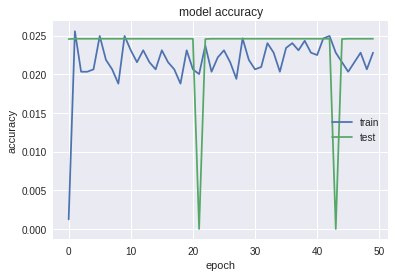

In [10]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

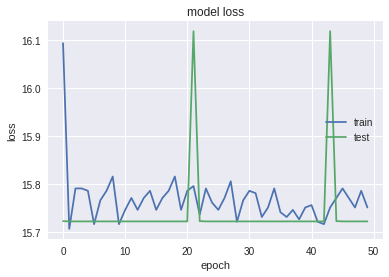

In [11]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

In [13]:
predictions = model.predict_generator(
    test_generator, test_generator.n // test_generator.batch_size, verbose=1
)

y_pred = np.argmax(predictions, axis=1)
y_true = integer_encoding(new_df['class'])

print(accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred))

scores = model.evaluate_generator(
    test_generator, test_generator.n // test_generator.batch_size, verbose=1
)

print('The accuracy is: {}'.format(str(scores[1]*100.0)))

1671/1671 [==============================] - 14s 9ms/step
0.011370436864153202
              precision    recall  f1-score   support

           0       0.01      1.00      0.02        19
           1       0.00      0.00      0.00        22
           2       0.00      0.00      0.00        51
           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         7
           5       0.00      0.00      0.00       217
           6       0.00      0.00      0.00       125
           7       0.00      0.00      0.00         6
           8       0.00      0.00      0.00        59
           9       0.00      0.00      0.00         3
          10       0.00      0.00      0.00         1
          11       0.00      0.00      0.00       274
          12       0.00      0.00      0.00        74
          13       0.00      0.00      0.00        15
          14       0.00      0.00      0.00        19
          15       0.00      0.00      0.00         3
  

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


1671/1671 [==============================] - 16s 9ms/step
The accuracy is: 3.53081986834231


In [0]:
savetxt('Trail Scores.txt', scores)
savetxt('Trail Predictions.txt', predictions)

In [14]:
# model 2
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(image_size,image_size,3)))
# model.add(Conv2D(32, (3, 3), input_shape=input_shape, use_bias= False, bias_initializer='zeros'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

opt = adam(lr=0.00001)
model.compile(loss='categorical_crossentropy',
             optimizer=opt, metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 254, 254, 32)      896       
_________________________________________________________________
activation_4 (Activation)    (None, 254, 254, 32)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 125, 125, 32)      9248      
_________________________________________________________________
activation_5 (Activation)    (None, 125, 125, 32)      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 60, 60, 64)        18496     
__________

In [15]:
csv_logger1 = CSVLogger('trail1_model_training.log')
history = model.fit_generator(
    train_generator,
    steps_per_epoch=math.ceil(train_generator.n//train_generator.batch_size),
    epochs=50,
    validation_data=validation_generator,
    validation_steps=math.ceil(validation_generator.samples //
                      validation_generator.batch_size),
    callbacks=[csv_logger1, es],
    use_multiprocessing=True,
    workers=0
)

Epoch 1/50
51/51 [==============================] - 31s 611ms/step - loss: 14.2847 - acc: 0.1020 - val_loss: 12.9593 - val_acc: 0.1960
Epoch 2/50
51/51 [==============================] - 28s 554ms/step - loss: 13.0886 - acc: 0.1869 - val_loss: 12.9593 - val_acc: 0.1960
Epoch 3/50
51/51 [==============================] - 28s 559ms/step - loss: 13.0805 - acc: 0.1869 - val_loss: 12.9593 - val_acc: 0.1960
Epoch 4/50
51/51 [==============================] - 29s 569ms/step - loss: 13.0734 - acc: 0.1875 - val_loss: 12.9593 - val_acc: 0.1960
Epoch 5/50
51/51 [==============================] - 29s 564ms/step - loss: 13.0786 - acc: 0.1851 - val_loss: 12.9593 - val_acc: 0.1960
Epoch 6/50
51/51 [==============================] - 29s 561ms/step - loss: 13.0679 - acc: 0.1875 - val_loss: 13.5839 - val_acc: 0.1572
Epoch 7/50
51/51 [==============================] - 28s 553ms/step - loss: 13.0780 - acc: 0.1863 - val_loss: 13.7280 - val_acc: 0.1483
Epoch 8/50
51/51 [==============================] - 28s

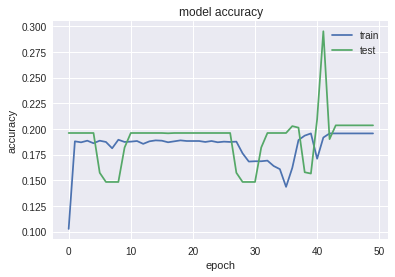

In [16]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

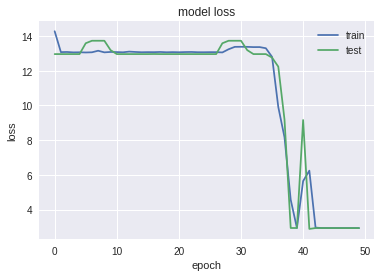

In [17]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

In [18]:
predictions = model.predict_generator(
    test_generator, test_generator.n // test_generator.batch_size, verbose=1
)

y_pred = np.argmax(predictions, axis=1)
y_true = integer_encoding(new_df['class'])

print(accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred))

scores = model.evaluate_generator(
    test_generator, test_generator.n // test_generator.batch_size, verbose=1
)

print('The accuracy is: {}'.format(str(scores[1]*100.0)))

1671/1671 [==============================] - 10s 6ms/step
0.25074805505685216
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        19
           1       0.00      0.00      0.00        22
           2       0.00      0.00      0.00        51
           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         7
           5       0.00      0.00      0.00       217
           6       0.00      0.00      0.00       125
           7       0.00      0.00      0.00         6
           8       0.00      0.00      0.00        59
           9       0.00      0.00      0.00         3
          10       0.00      0.00      0.00         1
          11       0.00      0.00      0.00       274
          12       0.00      0.00      0.00        74
          13       0.00      0.00      0.00        15
          14       0.00      0.00      0.00        19
          15       0.00      0.00      0.00         3
   

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


1671/1671 [==============================] - 10s 6ms/step
The accuracy is: 0.17953321364452424


In [19]:
predictions = np.argmax(predictions, axis=-1) #multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]
print(predictions)

['Water', 'Water', 'Water', 'Water', 'Water', 'Water', 'Water', 'Water', 'Water', 'Water', 'Water', 'Water', 'Water', 'Water', 'Water', 'Water', 'Water', 'Water', 'Water', 'Water', 'Water', 'Water', 'Water', 'Water', 'Water', 'Water', 'Water', 'Water', 'Water', 'Water', 'Water', 'Water', 'Water', 'Water', 'Water', 'Water', 'Water', 'Water', 'Water', 'Water', 'Water', 'Water', 'Water', 'Water', 'Water', 'Water', 'Water', 'Water', 'Water', 'Water', 'Water', 'Water', 'Water', 'Water', 'Water', 'Water', 'Water', 'Water', 'Water', 'Water', 'Water', 'Water', 'Water', 'Water', 'Water', 'Water', 'Water', 'Water', 'Water', 'Water', 'Water', 'Water', 'Water', 'Water', 'Water', 'Water', 'Water', 'Water', 'Water', 'Water', 'Water', 'Water', 'Water', 'Water', 'Water', 'Water', 'Water', 'Water', 'Water', 'Water', 'Water', 'Water', 'Water', 'Water', 'Water', 'Water', 'Water', 'Water', 'Water', 'Water', 'Water', 'Water', 'Water', 'Water', 'Water', 'Water', 'Water', 'Water', 'Water', 'Water', 'Water', 

In [20]:
# model 3
model = Sequential()

model.add(Conv2D(20,(3,3),input_shape=(image_size, image_size, 3)))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Conv2D(20,(3,3)))
model.add(Activation('relu'))
model.add(Dropout(0.5))


model.add(Flatten())
model.add(Dense(80))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

opt = adam(lr=0.00001)
model.compile(loss='categorical_crossentropy',
             optimizer=opt, metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 254, 254, 20)      560       
_________________________________________________________________
activation_9 (Activation)    (None, 254, 254, 20)      0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 254, 254, 20)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 252, 252, 20)      3620      
_________________________________________________________________
activation_10 (Activation)   (None, 252, 252, 20)      0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 252, 252, 20)      0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1270080)           0         
__________

In [21]:
csv_logger2 = CSVLogger('trail2_model_training.log')

history = model.fit_generator(
    train_generator,
    steps_per_epoch=math.ceil(train_generator.n//train_generator.batch_size),
    epochs=50,
    validation_data=validation_generator,
    validation_steps=math.ceil(validation_generator.samples //
                      validation_generator.batch_size),
    callbacks=[csv_logger2, es],
    use_multiprocessing=True,
    workers=0
)

Epoch 1/50
51/51 [==============================] - 53s 1s/step - loss: 15.0734 - acc: 0.0640 - val_loss: 14.3766 - val_acc: 0.1080
Epoch 2/50
51/51 [==============================] - 48s 945ms/step - loss: 14.4637 - acc: 0.1026 - val_loss: 14.3766 - val_acc: 0.1080
Epoch 3/50
51/51 [==============================] - 48s 937ms/step - loss: 14.4439 - acc: 0.1039 - val_loss: 14.3766 - val_acc: 0.1080
Epoch 4/50
51/51 [==============================] - 47s 929ms/step - loss: 14.4439 - acc: 0.1039 - val_loss: 14.3766 - val_acc: 0.1080
Epoch 5/50
51/51 [==============================] - 48s 944ms/step - loss: 14.4688 - acc: 0.1023 - val_loss: 14.3766 - val_acc: 0.1080
Epoch 6/50
51/51 [==============================] - 48s 935ms/step - loss: 14.4488 - acc: 0.1036 - val_loss: 14.3766 - val_acc: 0.1080
Epoch 7/50
51/51 [==============================] - 48s 934ms/step - loss: 14.4538 - acc: 0.1033 - val_loss: 15.0612 - val_acc: 0.0656
Epoch 8/50
51/51 [==============================] - 48s 93

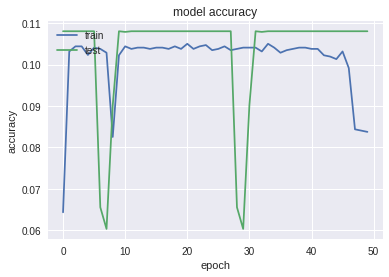

In [22]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

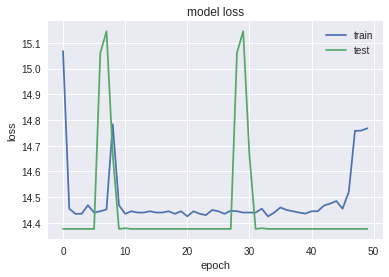

In [23]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

In [24]:
predictions = model.predict_generator(
    test_generator, test_generator.n // test_generator.batch_size, verbose=1
)

y_pred = np.argmax(predictions, axis=1)
y_true = integer_encoding(new_df['class'])

print(accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred))

scores = model.evaluate_generator(
    test_generator, test_generator.n // test_generator.batch_size, verbose=1
)

print('The accuracy is: {}'.format(str(scores[1]*100.0)))

1671/1671 [==============================] - 27s 16ms/step
0.1298623578695392
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        19
           1       0.00      0.00      0.00        22
           2       0.00      0.00      0.00        51
           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         7
           5       0.13      1.00      0.23       217
           6       0.00      0.00      0.00       125
           7       0.00      0.00      0.00         6
           8       0.00      0.00      0.00        59
           9       0.00      0.00      0.00         3
          10       0.00      0.00      0.00         1
          11       0.00      0.00      0.00       274
          12       0.00      0.00      0.00        74
          13       0.00      0.00      0.00        15
          14       0.00      0.00      0.00        19
          15       0.00      0.00      0.00         3
   

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


1671/1671 [==============================] - 28s 17ms/step
The accuracy is: 0.059844404548174746


In [7]:
# model 4
model = Sequential()
model.add(Conv2D(input_shape=(image_size, image_size, 3), filters=32, 
                 use_bias=True, kernel_size=(3,3)))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Conv2D(filters=64, use_bias=False, kernel_size=(5,5), strides=2))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(num_classes, activation="softmax"))
opt = adam(lr=0.00001)
model.compile(loss='categorical_crossentropy',
             optimizer=opt, metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 254, 254, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 254, 254, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 64)      51200     
_________________________________________________________________
activation_1 (Activation)    (None, 125, 125, 64)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 125, 125, 64)      0         
_________________________________________________________________
flatten (Flatten)            (None, 1000000)           0         
__________

In [9]:
csv_logger3 = CSVLogger('trail3_model_training.log')

history = model.fit_generator(
    train_generator,
    steps_per_epoch=math.ceil(train_generator.n//train_generator.batch_size),
    epochs=50,
    validation_data=validation_generator,
    validation_steps=math.ceil(validation_generator.samples //
                      validation_generator.batch_size),
    callbacks=[csv_logger3, es],
    use_multiprocessing=True,
    workers=0
)

Epoch 1/50
51/51 [==============================] - 56s 1s/step - loss: 15.8218 - acc: 0.0184 - val_loss: 15.8178 - val_acc: 0.0186
Epoch 2/50
51/51 [==============================] - 56s 1s/step - loss: 15.8218 - acc: 0.0184 - val_loss: 15.8178 - val_acc: 0.0186
Epoch 3/50
51/51 [==============================] - 56s 1s/step - loss: 15.8218 - acc: 0.0184 - val_loss: 15.8178 - val_acc: 0.0186
Epoch 4/50
51/51 [==============================] - 56s 1s/step - loss: 15.8218 - acc: 0.0184 - val_loss: 15.8178 - val_acc: 0.0186
Epoch 5/50
51/51 [==============================] - 56s 1s/step - loss: 15.8218 - acc: 0.0184 - val_loss: 15.8178 - val_acc: 0.0186
Epoch 6/50
51/51 [==============================] - 56s 1s/step - loss: 15.8218 - acc: 0.0184 - val_loss: 15.8178 - val_acc: 0.0186
Epoch 00006: early stopping


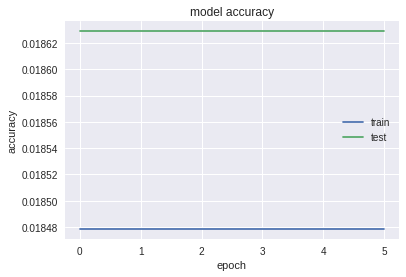

In [10]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

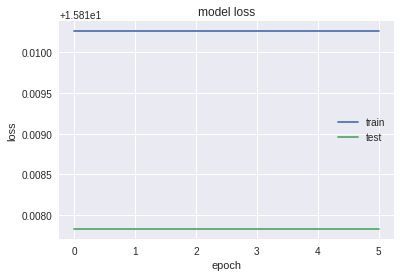

In [11]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

In [12]:
predictions = model.predict_generator(
    test_generator, test_generator.n // test_generator.batch_size, verbose=1
)

y_pred = np.argmax(predictions, axis=1)
y_true = integer_encoding(new_df['class'])

print(accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred))

scores = model.evaluate_generator(
    test_generator, test_generator.n // test_generator.batch_size, verbose=1
)

print('The accuracy is: {}'.format(str(scores[1]*100.0)))

1671/1671 [==============================] - 25s 15ms/step
0.013165769000598444
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        19
           1       0.01      1.00      0.03        22
           2       0.00      0.00      0.00        51
           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         7
           5       0.00      0.00      0.00       217
           6       0.00      0.00      0.00       125
           7       0.00      0.00      0.00         6
           8       0.00      0.00      0.00        59
           9       0.00      0.00      0.00         3
          10       0.00      0.00      0.00         1
          11       0.00      0.00      0.00       274
          12       0.00      0.00      0.00        74
          13       0.00      0.00      0.00        15
          14       0.00      0.00      0.00        19
          15       0.00      0.00      0.00         3
 

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


1671/1671 [==============================] - 26s 16ms/step
The accuracy is: 19.449431478156793


In [9]:
# model 5
model = Sequential()
model.add(Conv2D(input_shape=(image_size, image_size,3), filters=96, kernel_size=(3,3)))
model.add(Activation('relu'))
model.add(Conv2D(filters=96, kernel_size=(3,3), strides=2))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Conv2D(filters=192, kernel_size=(3,3)))
model.add(Activation('relu'))
model.add(Conv2D(filters=192, kernel_size=(3,3), strides=2))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dense(num_classes, activation="softmax"))
opt = adam(lr=0.00001)
model.compile(loss='categorical_crossentropy',
             optimizer=opt, metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 96)      2688      
_________________________________________________________________
activation (Activation)      (None, 254, 254, 96)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 126, 126, 96)      83040     
_________________________________________________________________
activation_1 (Activation)    (None, 126, 126, 96)      0         
_________________________________________________________________
dropout (Dropout)            (None, 126, 126, 96)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 124, 124, 192)     166080    
_________________________________________________________________
activation_2 (Activation)    (None, 124, 124, 192)     0         
__________

In [10]:
csv_logger4 = CSVLogger('trail4_model_training.log')

history = model.fit_generator(
    train_generator,
    steps_per_epoch=math.ceil(train_generator.n//train_generator.batch_size),
    epochs=50,
    validation_data=validation_generator,
    validation_steps=math.ceil(validation_generator.samples //
                      validation_generator.batch_size),
    callbacks=[csv_logger4, es],
    use_multiprocessing=True,
    workers=0
)

Epoch 1/50


ResourceExhaustedError: ignored

In [0]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

In [0]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

In [0]:
predictions = model.predict_generator(
    test_generator, test_generator.n // test_generator.batch_size, verbose=1
)

y_pred = np.argmax(predictions, axis=1)
y_true = integer_encoding(new_df['class'])

print('precision: {}'.format(str(accuracy_score(y_true, y_pred) * 100.0)))
print(classification_report(y_true, y_pred))

precision, recall, fscore, support = score(y_true, y_pred)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

scores = model.evaluate_generator(
    test_generator, test_generator.n // test_generator.batch_size, verbose=1
)

print('The accuracy is: {}'.format(str(scores[1]*100.0)))

In [14]:
# Model 6
model.add(Conv2D(32, (3, 3), input_shape=(256, 256, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.1))

model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
model.summary()

TypeError: ignored

In [0]:
csv_logger5 = CSVLogger('trail5_model_training.log')

history = model.fit_generator(
    train_generator,
    steps_per_epoch=math.ceil(train_generator.n//train_generator.batch_size),
    epochs=50,
    validation_data=validation_generator,
    validation_steps=math.ceil(validation_generator.samples //
                      validation_generator.batch_size),
    callbacks=[csv_logger5, es],
    use_multiprocessing=True,
    workers=0
)

In [0]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

In [0]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

In [0]:
predictions = model.predict_generator(
    test_generator, test_generator.n // test_generator.batch_size, verbose=1
)

y_pred = np.argmax(predictions, axis=1)
y_true = integer_encoding(new_df['class'])

print(accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred))

scores = model.evaluate_generator(
    test_generator, test_generator.n // test_generator.batch_size, verbose=1
)

print('The accuracy is: {}'.format(str(scores[1]*100.0)))

In [15]:
from tensorflow.python.keras.layers import Activation,Dropout,BatchNormalization,Dense,Convolution2D,Flatten

model = Sequential()

model.add(Convolution2D(20,(3,3),input_shape=(256, 256, 3)))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Convolution2D(20,(3,3)))
model.add(Activation('relu'))
model.add(Dropout(0.5))


model.add(Flatten())
model.add(Dense(80))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(19))
model.add(Activation('softmax'))


model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 254, 254, 20)      560       
_________________________________________________________________
activation_5 (Activation)    (None, 254, 254, 20)      0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 254, 254, 20)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 252, 252, 20)      3620      
_________________________________________________________________
activation_6 (Activation)    (None, 252, 252, 20)      0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 252, 252, 20)      0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1270080)           0         
__________

In [16]:
csv_logger5 = CSVLogger('trail5_model_training.log')

history = model.fit_generator(
    train_generator,
    steps_per_epoch=math.ceil(train_generator.n//train_generator.batch_size),
    epochs=50,
    validation_data=validation_generator,
    validation_steps=math.ceil(validation_generator.samples //
                      validation_generator.batch_size),
    callbacks=[csv_logger5, es],
    use_multiprocessing=True,
    workers=0
)

Epoch 1/50
51/51 [==============================] - 55s 1s/step - loss: 15.7325 - acc: 0.0239 - val_loss: 15.7223 - val_acc: 0.0246
Epoch 2/50
51/51 [==============================] - 51s 991ms/step - loss: 15.5650 - acc: 0.0343 - val_loss: 15.7217 - val_acc: 0.0246
Epoch 3/50
51/51 [==============================] - 50s 975ms/step - loss: 15.5946 - acc: 0.0325 - val_loss: 15.7217 - val_acc: 0.0246
Epoch 4/50
51/51 [==============================] - 50s 971ms/step - loss: 15.5551 - acc: 0.0349 - val_loss: 15.7217 - val_acc: 0.0246
Epoch 5/50
51/51 [==============================] - 49s 969ms/step - loss: 14.8050 - acc: 0.0812 - val_loss: 13.2596 - val_acc: 0.1773
Epoch 6/50
51/51 [==============================] - 49s 968ms/step - loss: 13.5302 - acc: 0.1606 - val_loss: 13.4758 - val_acc: 0.1639
Epoch 7/50
51/51 [==============================] - 50s 971ms/step - loss: 13.5599 - acc: 0.1587 - val_loss: 13.4758 - val_acc: 0.1639
Epoch 8/50
51/51 [==============================] - 50s 97

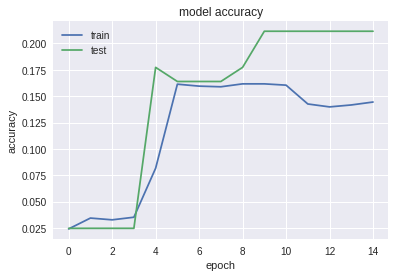

In [17]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

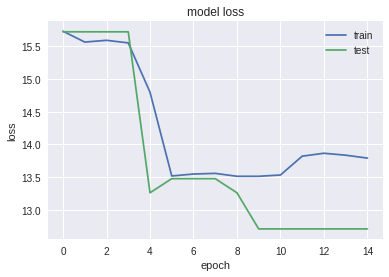

In [18]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

In [19]:
predictions = model.predict_generator(
    test_generator, test_generator.n // test_generator.batch_size, verbose=1
)

y_pred = np.argmax(predictions, axis=1)
y_true = integer_encoding(new_df['class'])

print('precision: {}'.format(str(accuracy_score(y_true, y_pred) * 100.0)))
print(classification_report(y_true, y_pred))

precision, recall, fscore, support = score(y_true, y_pred)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

scores = model.evaluate_generator(
    test_generator, test_generator.n // test_generator.batch_size, verbose=1
)

print('The accuracy is: {}'.format(str(scores[1]*100.0)))

1671/1671 [==============================] - 27s 16ms/step
precision: 19.449431478156793
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        19
           1       0.00      0.00      0.00        22
           2       0.00      0.00      0.00        51
           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         7
           5       0.00      0.00      0.00       217
           6       0.00      0.00      0.00       125
           7       0.00      0.00      0.00         6
           8       0.00      0.00      0.00        59
           9       0.00      0.00      0.00         3
          10       0.00      0.00      0.00         1
          11       0.00      0.00      0.00       274
          12       0.00      0.00      0.00        74
          13       0.00      0.00      0.00        15
          14       0.00      0.00      0.00        19
          15       0.00      0.00      0.00   

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


1671/1671 [==============================] - 28s 16ms/step
The accuracy is: 0.17953321364452424


In [0]:
# https://stats.stackexchange.com/questions/352036/what-should-i-do-when-my-neural-network-doesnt-learn
# https://stats.stackexchange.com/questions/272607/cifar-10-cant-get-above-60-accuracy-keras-with-tensorflow-backend

# law lesa mazbatitsh hashyl el rescale
# Model 1, 
# Model 2, 
# Model 3, 
# Model 4, 
# Model 5, 
# Model 6, 